# Visual learning and unsupervised plasticity with large-scale neural recordings
#### data from [Zhong et al, 2025](https://www.nature.com/articles/s41586-025-09180-y)

This dataset consists of simultaneous neural recordings from over 50,000 neurons, while mice perform a visual discrimination task in virtual reality. Mice are rewarded with water when they lick in the correct corridor.

Recordings are made with a two-photon large field of view mesoscope, spanning primary visual cortex as well as higher-order visual areas (medial, anterior, lateral).

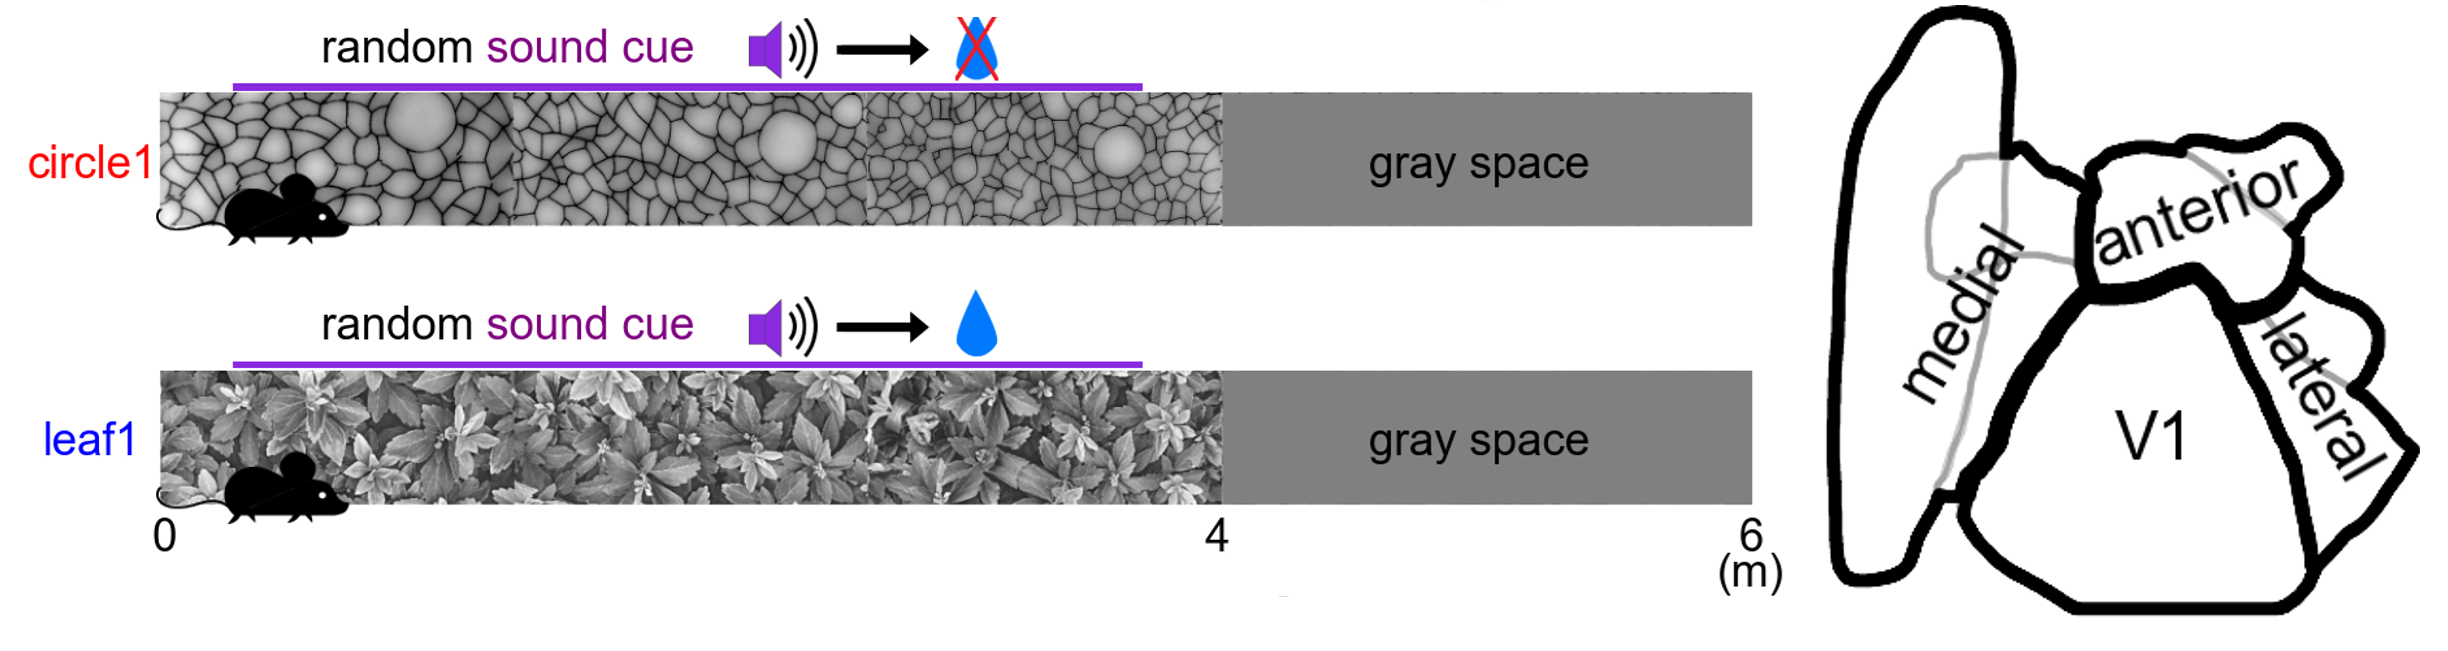

Recording are made before and after training ("train1" session), as well as with new stimuli ("test1" session). The new stimuli are similar, but not identical to the trained ones. Mice likely perceive these as novel.  

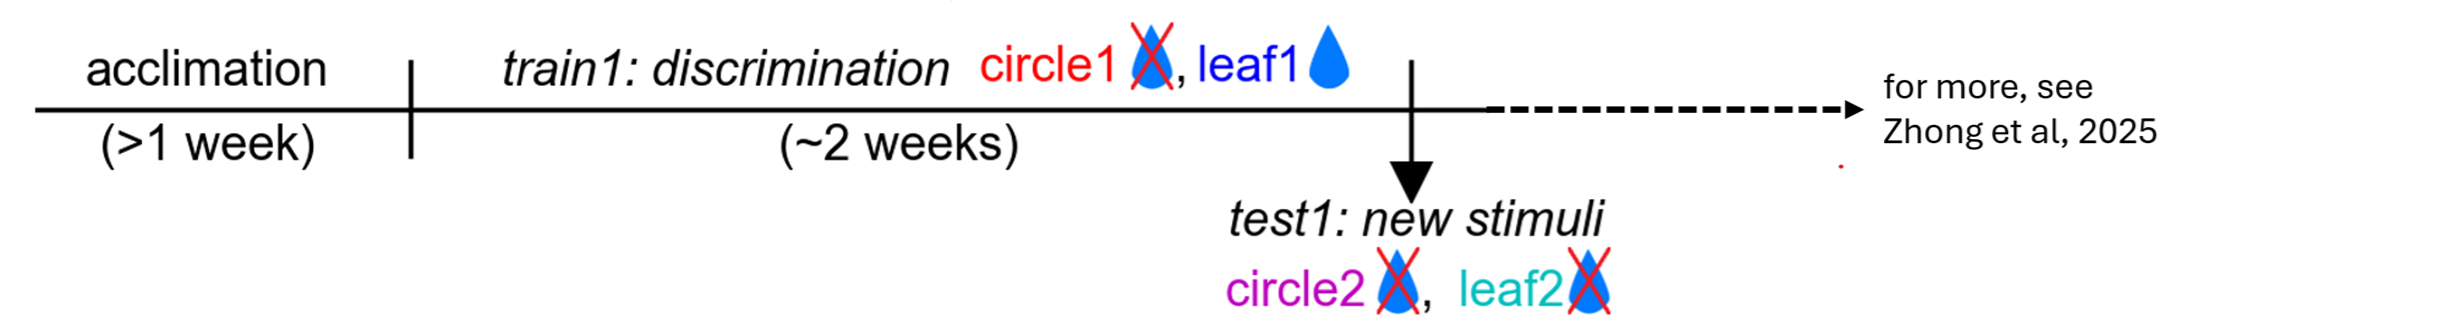

In [1]:
# @title Import packages
from pathlib import Path
import json
import requests
import os
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# @title Data loading and imports

# set path for data
root = r'/content/Zhong_et_al_2025'
Path(root).mkdir(exist_ok=True)

# files required for this project: 'VR2_2021_03_20_1_example_raw_spk.npy'; 'VR2_2021_03_20_1_SVD_dec.npy'; 'VR2_2021_03_20_trans.npz'; 'VR2_2021_04_06_1_SVD_dec.npy'; 'VR2_2021_04_06_trans.npz';
#        'TX105_2022_10_08_2_SVD_dec.npy'; 'TX105_2022_10_08_trans.npz'; 'TX105_2022_10_19_2_SVD_dec.npy'; 'TX105_2022_10_19_trans.npz'
#        'Beh_sup_train1_before_learning.npy'; 'Beh_sup_train1_after_learning.npy'; 'Beh_unsup_train1_before_learning.npy'; 'Beh_unsup_train1_after_learning.npy'
sup_bef = 'VR2_2021_03_20_1' #example mouse before supervised learning
sup_aft = 'VR2_2021_04_06_1' #example mouse after supervised learning
unsup_bef = 'TX105_2022_10_08_2' #example mouse before supervised learning
unsup_aft = 'TX105_2022_10_19_2' #example mouse after supervised learning

# download files from Figshare
file_ID = [54866153, 54866354, 54184211, 54866333, 54184214, 54866237, 54184028, 54866150, 54184031, 54183863, 54183860, 54183914, 54183917] # IDs of files

BASE_URL = 'https://api.figshare.com/v2'
r = requests.get(BASE_URL + '/articles/' + str(28811129)) # 28811129 is the ID of the whole dataset
file_metadata = json.loads(r.text)
for file in file_metadata['files']:
  if file['id'] in file_ID: # only download files included in file_ID
    fn = os.path.join(root, file['name'])
    if not os.path.isfile(fn):
      response = requests.get(BASE_URL + '/file/download/' + str(file['id']))
      open(fn, 'wb').write(response.content)
    #print(fn)

# Definition of variables in Behavior data
Variables inside `beh`:
*   `beh['ntrials']`: number of trials
*   `beh['trInd']`: trials index
*   `beh['trInd_odd']`: the index of odd trials
*   `beh['trInd_even']`: the index of even trials
*   `beh['Trial_start_time']`: time when animal enters each corridor
*   `beh['Trial_end_time']`: time when animal ran out each corridor
*   `beh['stim_id']`: ID of stimuli;  0:circle1, 1:circle2, 2:leaf1, 3:leaf2 4:leaf3, 5:leaf1_swap1, 6:leaf1_swap2
*   `beh['SubjMove']`: running information
  *   `beh['SubjMove']['SubjMTime']`: time stamps of running
  *   `beh['SubjMove']['SubjMPos']`: position inside corridor
  *   `beh['SubjMove']['SubjMPosCum']`: cumulative position inside VR
  *   `beh['SubjMove']['SubjMDistCum']`: almost identical with `beh['SubjMove']['SubjMPosCum']`
  *   `beh['SubjMove']['SubjM_pitch']`: pitch (forward) running speed
  *   `beh['SubjMove']['SubjM_roll']`: roll direction running speed  
  *   `beh['SubjMove']['SubjM_yaw']`: yaw direction running speed    
  *   `beh['SubjMove']['SubjM_pitch_cum']`: total running distance. Note that it is not the same as `beh['SubjMove']['SubjMPosCum']` given that we only move the VR and with a constant speed when `beh['SubjMove']['SubjM_pitch']` pass a threshold
*   `beh['Gray_space_time']`: time when animal entered the gray space
*   `beh['SoundPos']`: position of sound cue
*   `beh['SoundTime']`: time of sound cue
*   `beh['SoundTimeDelay']`: time of sound cue with a delay, if delay=0, then it is the same as `beh['SoundTime']`
*   `beh['RewTime']`: time of reward delivery, these numbers only valid in the reward corridor.
*   `beh['RewPos']`: position of reward delivery, with NaN in the non-reward corridor.
*   `beh['isRew']`: boolean value indicating if the trial is a reward trial.
*   `beh['WallType']`: category of stimuli, but please ignore this one since it doesn't apply to our experiments
*   `beh['WallIsProbe']`: whether is a catch trial, but please ignore this one
*   `beh['WallName']`: name of stimuli in each corridor
*   `beh['UniqWalls']`: name of stimuli in the whole session
*   `beh['LickTrind']`: trial stamp of each lick
*   `beh['LickTime']`: time stamp of each lick
*   `beh['LickPos']`: positional stamp of each lick
*   `beh['Lick_wallName']`: corresponding stimulus of each lick
*   `beh['VRpos']`: position inside VR
*   `beh['VRposCum']`: cumulative position inside VR
*   `beh['VRposTime']`: time stamp for `beh['VRpos']` and `beh['VRposCum']`
*   `beh['ft']`: time stamp for each neural frame
*   `beh['ft_trInd']`: trial stamp for each neural frame, NaN means outside the behavior recorded
*   `beh['ft_trInd_odd']`: neural frames from odd trials
*   `beh['ft_trInd_even']`: neural frames from even trials
*   `beh['ft_Pos']`: position inside VR for each neural frame
*   `beh['ft_PosCum']`: culculative position inside VR for each neural frame
*   `beh['ft_move']`: the differences between each frame of `beh['ft_PosCum']`
*   `beh['ft_isMoving']`: boolean value for `beh['ft_move']>0`
*   `beh['ft_GraySpc']`: boolean value indicating if animals is inside gray space
*   `beh['ft_CorrSpc']`: boolean value indicating if animals is inside texture area
*   `beh['ft_WallID']`: the corridor each neural frame belongs to
*   `beh['ft_RunCum']`: cumulative running distance for each neural frame
*   `beh['ft_RunSpeed']`: running speed for each neural frame
*   `beh['RunFr']`: same as `beh['ft_RunSpeed']`
*   `beh['run_pos']`: running speed interpolated into trials * positions
*   `beh['RewardFr']`: neural frame when reward was delivered, length=ntrials, NaN means trial without reward being delivered
*   `beh['StartFr']`: neural frame when animal enter each corridor
*   `beh['GrayFr']`: neural frame when animal enter gray space
*   `beh['EndFr']`: neural frame when animal ran out of a corridor
*   `beh['LickFr']`: neural frame when animal licked
*   `beh['SoundFr']`: neural frame when sound cue was delivered
*   `beh['SoundDelayFr']`: neural frame when cound cue was delivered + a delay, if delay=0, then it is the same as `beh['SoundFr']`
*   `beh['SoundDelPos']`: position inside a corridor, corresponding to `beh['SoundDelayFr']`
*   `beh['BefCueFr']`: boolean values indicating neural frames after entered corridor but before cue was delivered
*   `beh['AftCueFr']`: boolean values indicating neural frames after cue was delivered
*   `beh['TrialStim']`: stimulus name of each trial
*   `beh['StimTrial']`: subfields are trial index of each stimulus
*   `beh['StimFrame']`: subfields are neural frame index of each stimulus

Below are some settings:
*   `beh['Corridor_Length']`: length of the corridor
*   `beh['Gray_Space_length']`: length of gray space
*   `beh['Texture_Length']`: length of texture area
*   `beh['Reward_Mode']`: reward mode of experiment, either passive reward in which reward was delivered without lick  or active reward in which reward was triggered be licking
*   `beh['Reward_Delay_ms']`: delay time for reward, this is a setting. Find the actually reward time in `beh['RewTime']`

In [3]:
# @title Loading raw data from 1000 neurons
example_raw_data = np.load(os.path.join(root, sup_bef + '_example_raw_spk.npy'))
nfrs = example_raw_data.shape[1]
print('Shape of example_raw_data (neurons * frames):', example_raw_data.shape)

Shape of example_raw_data (neurons * frames): (1000, 24298)


In [4]:
# @title Load behavioral data

beh = np.load(os.path.join(root, 'Beh_sup_train1_before_learning.npy'), allow_pickle=1).item()[sup_bef]
print(beh.keys())

stim_id = beh['stim_id'] # 0:circle1, 1:circle2, 2:leaf1, 3:leaf2, 4:leaf3
ntrials, uniqW, WallN = beh['ntrials'], beh['UniqWalls'], beh['WallName']
SoundPos = beh['SoundPos']

lick_fr = beh['LickFr'] # frame with lick
cue_fr = beh['SoundFr'] # frame with cue
stim_fr = beh['ft_WallID'] # trial stimulus of each frame
pos_fr = beh['ft_Pos'] # position of each frame inside corridor
cum_pos_fr = beh['ft_PosCum']
VR_move = beh['ft_move']>0 # frames with virtual scene moving

name_stim1 = uniqW[stim_id==2][0] # name of stimulus 1; rewarded stimulus (leaf1) for supervised experiment
name_stim2 = uniqW[stim_id==0][0] # name of stimulus 2; non-rewarded stimulus (circle1) for supervised experiment
stim1_tr = WallN==name_stim1
stim2_tr = WallN==name_stim2

# get index of frame within stimulus 1 (0-40 is within texture area, 40-60 is gray space)
stim1_idx = (stim_fr==name_stim1) & (pos_fr<40)
stim2_idx = (stim_fr==name_stim2) & (pos_fr<40)
gray_idx = ((stim_fr==name_stim1) | (stim_fr==name_stim2)) & (pos_fr>=40)

dict_keys(['ntrials', 'trInd', 'trInd_odd', 'trInd_even', 'Trial_start_time', 'Trial_end_time', 'SubjMove', 'Gray_space_time', 'SoundPos', 'SoundTime', 'SoundTimeDelay', 'RewTime', 'RewPos', 'isRew', 'WallType', 'WallIsProbe', 'WallName', 'UniqWalls', 'LickTrind', 'LickTime', 'LickPos', 'Lick_wallName', 'VRposTime', 'VRpos', 'VRposCum', 'ft', 'ft_trInd', 'ft_trInd_odd', 'ft_trInd_even', 'ft_PosCum', 'ft_Pos', 'ft_move', 'ft_isMoving', 'ft_GraySpc', 'ft_CorrSpc', 'ft_WallID', 'ft_RunCum', 'ft_RunSpeed', 'Corridor_Length', 'Gray_Space_length', 'Texture_Length', 'run_pos', 'RewardFr', 'StartFr', 'GrayFr', 'EndFr', 'LickFr', 'SoundFr', 'SoundDelayFr', 'SoundDelPos', 'RunFr', 'BefCueFr', 'AftCueFr', 'stim_id', 'TrialStim', 'StimTrial', 'StimFrame', 'Reward_Mode', 'Reward_Delay_ms'])


Text(0.5, 0, 'frames')

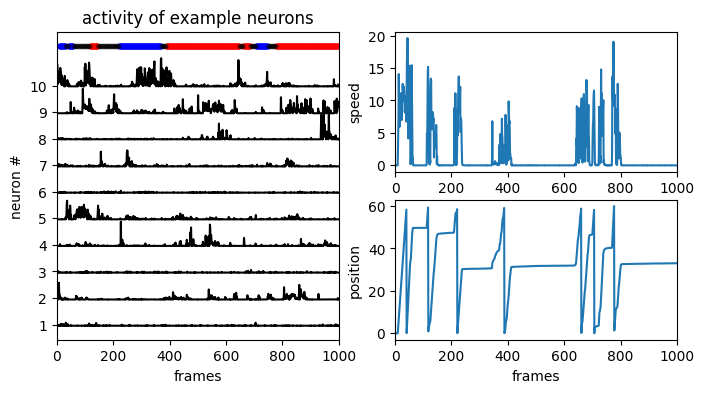

In [5]:
# @title Show example neural activity
nneu = 10
nfr = 1000

fig = plt.figure(figsize=(8, 4))
plt.subplot(1,2,1)
plt.plot(example_raw_data[0:nneu, 0:nfr].T + np.arange(nneu)*10, 'k-')

plt.plot(np.where(stim1_idx)[0], np.zeros(stim1_idx.sum()) + nneu*10 + 5, 'b.') # blue means inside stimulus 1
plt.plot(np.where(stim2_idx)[0], np.zeros(stim2_idx.sum()) + nneu*10 + 5, 'r.') # red means inside stimulus 2
plt.plot(np.where(gray_idx)[0], np.zeros(gray_idx.sum()) + nneu*10 + 5, 'k.', alpha=0.1) # grey means inside grey space

plt.yticks(np.arange(nneu)*10, np.arange(nneu)+1)
plt.xlim([0, nfr])
plt.ylabel('neuron #')
plt.xlabel('frames')
plt.title('activity of example neurons')

plt.subplot(2,2,2)
plt.plot(beh['RunFr'][:nfr])
plt.xlim([0, nfr])
plt.ylabel('speed')

plt.subplot(2,2,4)
plt.plot(pos_fr[:nfr])
plt.xlim([0, nfr])
plt.ylabel('position')
plt.xlabel('frames')


In [6]:
# @title Reconstructing neural activity as neurons * trials * positions
from scipy import interpolate
def interp_value(v, vind, tind):
    """v: value; vind: index; tind: target index"""
    Model_ = interpolate.interp1d(vind, v, fill_value='extrapolate')
    return Model_(tind)

max_cum_pos = ntrials * 60 # length of corrior is 60 decimeters (6 meters)
interp_spk = np.empty((example_raw_data.shape[0], max_cum_pos))
for i in range(example_raw_data.shape[0]):
    interp_spk[i] = interp_value(example_raw_data[i], cum_pos_fr[:nfrs], np.arange(max_cum_pos))
interp_spk = interp_spk.reshape((interp_spk.shape[0], ntrials, 60))

/usr/local/lib/python3.11/dist-packages/scipy/interpolate/_interpolate.py:479: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/usr/local/lib/python3.11/dist-packages/scipy/interpolate/_interpolate.py:482: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/usr/local/lib/python3.11/dist-packages/scipy/interpolate/_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


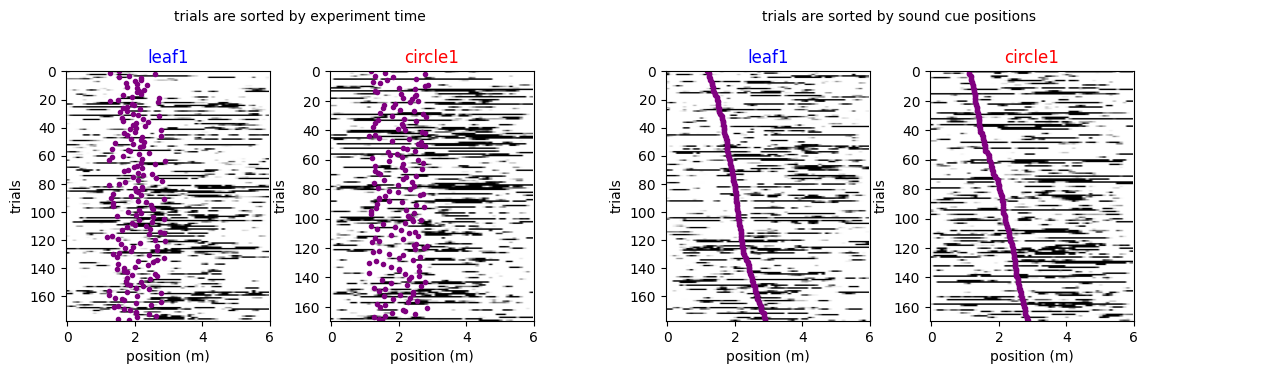

In [7]:
# @title Plot activity as trials by positions (example neuron)
def im_plot(ax, spk_in, cue_pos, sort_cue=0):
    sort_ind = np.argsort(cue_pos) if sort_cue else np.arange(len(cue_pos)).astype(int)
    ax.imshow(spk_in[sort_ind], cmap='gray_r', vmin=0, vmax=0.5)
    ax.plot(cue_pos[sort_ind], np.arange(len(cue_pos)), marker='.',color='purple', ls='None')
    ax.set_aspect('auto')
    ax.set_ylabel('trials')
    ax.set_xlabel('position (m)')
    ax.set_xticks([0, 20, 40, 60], [0, 2, 4 ,6])

n = 41 # example neuron ID (try different neurons)

fig = plt.figure(figsize=(12, 2.5))
axes = [fig.add_axes([0, 0, 0.17, 1]), fig.add_axes([0.22, 0, 0.17, 1]), fig.add_axes([0.5, 0, 0.17, 1]), fig.add_axes([0.72, 0, 0.17, 1])]

# trials are sorted by experiment time
im_plot(axes[0], interp_spk[n, stim1_tr], SoundPos[stim1_tr], sort_cue=0)
axes[0].set_title('leaf1', color='b')

im_plot(axes[1], interp_spk[n, stim2_tr], SoundPos[stim2_tr], sort_cue=0)
axes[1].set_title('circle1', color='r')

# trials are sorted by sound cue positions
im_plot(axes[2], interp_spk[n, stim1_tr], SoundPos[stim1_tr], sort_cue=1)
axes[2].set_title('leaf1', color='b')

im_plot(axes[3], interp_spk[n, stim2_tr], SoundPos[stim2_tr], sort_cue=1)
axes[3].set_title('circle1', color='r')

text_ax = fig.add_axes([0, 0, 1, 1])
text_ax.axis('off')
text_ax.text(0.09, 1.2, 'trials are sorted by experiment time')
text_ax.text(0.58, 1.2, 'trials are sorted by sound cue positions')
plt.show()

In [8]:
# @title Calculate data reconstructions from PCA
svd_dec_400pc = np.load(os.path.join(root, sup_bef+'_SVD_dec.npy'), allow_pickle=1).item() # 400 PCs
proj_400pc = svd_dec_400pc['U'][:, :1000].T @ svd_dec_400pc['V'] # project from the PC space back to neural space (only do it for the first 1000 neuorns)

proj_40pc = svd_dec_400pc['U'][:40, :1000].T @ svd_dec_400pc['V'][:40] #construct spikes with first 40 PCs (only do it for the first 1000 neuorns)



/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator TruncatedSVD from version 1.6.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Text(0.5, 1.0, '400 PC reconstruction')

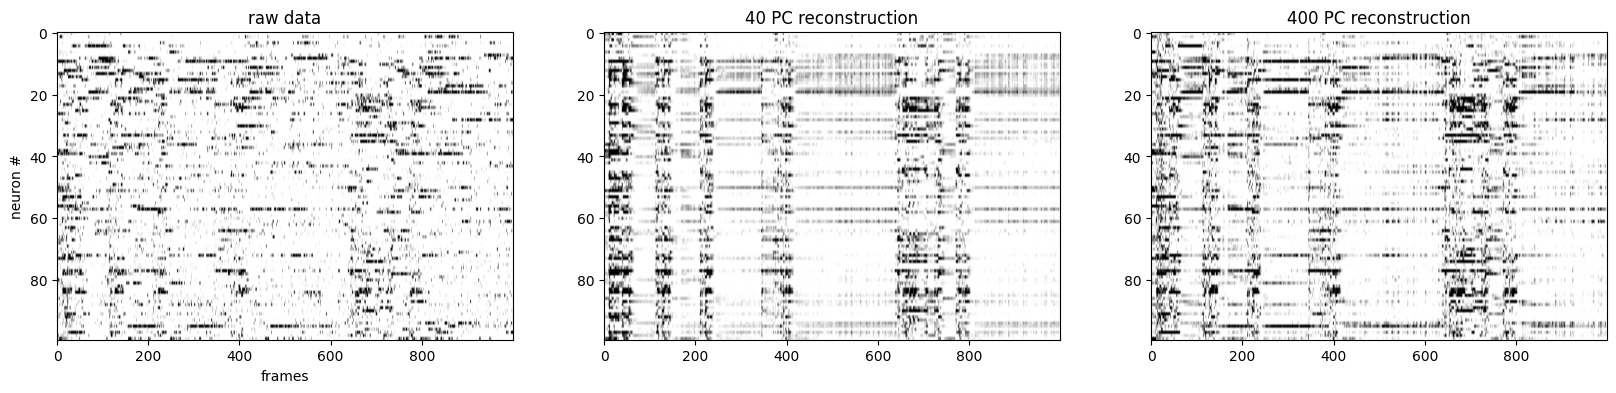

In [9]:
# @title Compare the analysis results on raw vs PCA-ed reconstructed data

nneu = 100
nfr = 1000

fig = plt.figure(figsize=(20, 4))
plt.subplot(131)
plt.imshow(example_raw_data[:nneu, 0:nfr], aspect = 'auto', vmax = 1, vmin = 0, cmap = 'gray_r')
plt.title('raw data')
plt.xlabel("frames")
plt.ylabel("neuron #")

plt.subplot(132)
plt.imshow(proj_40pc[:nneu, 0:nfr], aspect = 'auto', vmax = 1, vmin = 0, cmap = 'gray_r')
plt.title('40 PC reconstruction')

plt.subplot(133)
plt.imshow(proj_400pc[:nneu, 0:nfr], aspect = 'auto', vmax = 1, vmin = 0, cmap = 'gray_r')
plt.title('400 PC reconstruction')


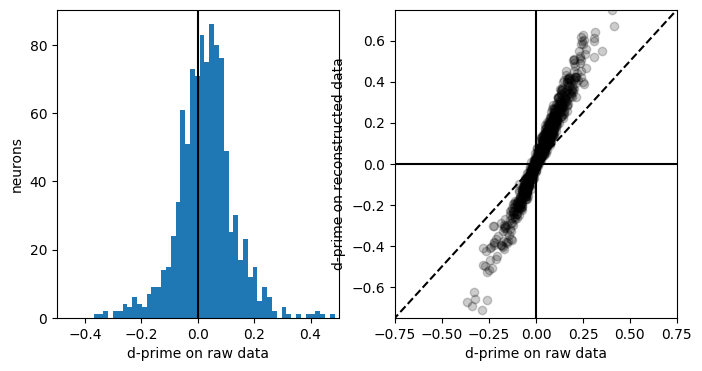

In [10]:
# @title Compare the d-prime computed on raw vs PCA-ed reconstructed data

# function for calculating one of the selective index: d-prime
def dprime(spk1, spk2):
    u1 = np.nanmean(spk1, axis=1) # take mean across frames
    u2 = np.nanmean(spk2, axis=1)
    sig1 = np.nanstd(spk1, axis=1)
    sig2 = np.nanstd(spk2, axis=1)
    dp = 2 * (u1 - u2) / (sig1 + sig2) # get d-prime
    return dp

idx1 = stim1_idx & VR_move # only take frames while mouse is running inside the texture area
idx2 = stim2_idx & VR_move

# calculate a selectivity index (d-prime)
dprime_raw = dprime(example_raw_data[:, idx1[:nfrs]], example_raw_data[:, idx2[:nfrs]]) # get d-prime

fig = plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.hist(dprime_raw, bins=50)
plt.axvline(0, color='k')
plt.xlabel('d-prime on raw data')
plt.ylabel('neurons')
plt.xlim([-0.5, 0.5])

dprime_pc = dprime(proj_400pc[:, idx1[:nfrs]], proj_400pc[:, idx2[:nfrs]]) # get d-prime

plt.subplot(122)
plt.plot([-1, 1], [-1, 1], 'k--')
plt.axvline(0, color='k')
plt.axhline(0, color='k')
plt.scatter(dprime_raw, dprime_pc, c='k', alpha=0.2)
plt.gca().set_aspect('auto')
plt.xlim([-0.75, 0.75])
plt.ylim([-0.75, 0.75])
plt.xlabel('d-prime on raw data');
plt.ylabel('d-prime on reconstructed data');

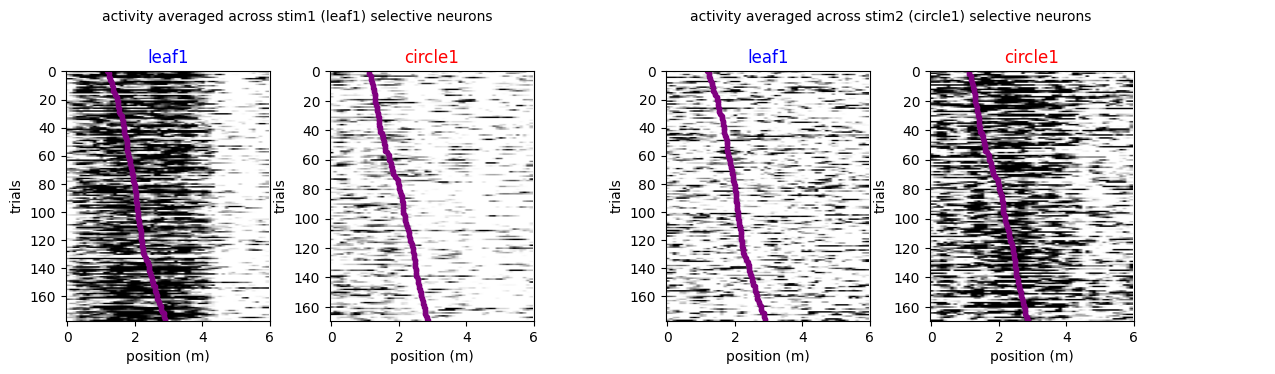

In [11]:
# @title Plot example selective neuron's activity

stim1_neurons = dprime_pc>=0.5
stim2_neurons = dprime_pc<=-0.5

fig = plt.figure(figsize=(12, 2.5))
axes = [fig.add_axes([0, 0, 0.17, 1]), fig.add_axes([0.22, 0, 0.17, 1]), fig.add_axes([0.5, 0, 0.17, 1]), fig.add_axes([0.72, 0, 0.17, 1])]

# stim2 selective neurons
im_plot(axes[0], interp_spk[stim1_neurons][:, stim1_tr].mean(0), SoundPos[stim1_tr], sort_cue=1)
axes[0].set_title('leaf1', color='b')

im_plot(axes[1], interp_spk[stim1_neurons][:, stim2_tr].mean(0), SoundPos[stim2_tr], sort_cue=1)
axes[1].set_title('circle1', color='r')

# stim2 selective neurons
im_plot(axes[2], interp_spk[stim2_neurons][:, stim1_tr].mean(0), SoundPos[stim1_tr], sort_cue=1)
axes[2].set_title('leaf1', color='b')

im_plot(axes[3], interp_spk[stim2_neurons][:, stim2_tr].mean(0), SoundPos[stim2_tr], sort_cue=1)
axes[3].set_title('circle1', color='r')

text_ax = fig.add_axes([0, 0, 1, 1])
text_ax.axis('off')
text_ax.text(0.03, 1.2, 'activity averaged across stim1 (leaf1) selective neurons')
text_ax.text(0.52, 1.2, 'activity averaged across stim2 (circle1) selective neurons')
plt.show()

In [12]:
# @title Calculating d-prime for all neurons (this will take a couple of minutes)

# load SVD decompositional spike and reconstruct activity from PCA for all neurons
svd_sup_bef = np.load(os.path.join(root, sup_bef+'_SVD_dec.npy'), allow_pickle=1).item()
proj = svd_sup_bef['U'].T @ svd_sup_bef['V'] # project from the PC space back to neural space
print('neurons * frames = ', proj.shape)

# option 1: you can use the function to get d-prime but it requires more RAM
# dprime_pc_bef = dprime(proj[:, idx1[:nfrs]], proj[:, idx2[:nfrs]])

# option 2: use a for loop which takes less RAM, but it takes longer time
u1, u2, sig1, sig2 = np.empty(proj.shape[0]), np.empty(proj.shape[0]), np.empty(proj.shape[0]), np.empty(proj.shape[0])
for n in range(proj.shape[0]): #looping through neurons
    u1[n] = np.nanmean(proj[n, idx1[:nfrs]])
    u2[n] = np.nanmean(proj[n, idx2[:nfrs]])
    sig1[n] = np.nanstd(proj[n, idx1[:nfrs]])
    sig2[n] = np.nanstd(proj[n, idx2[:nfrs]])
dprime_pc_bef = 2 * (u1 - u2) / (sig1 + sig2) # get d-prime

del proj # release RAM

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator TruncatedSVD from version 1.6.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


neurons * frames =  (81473, 24298)


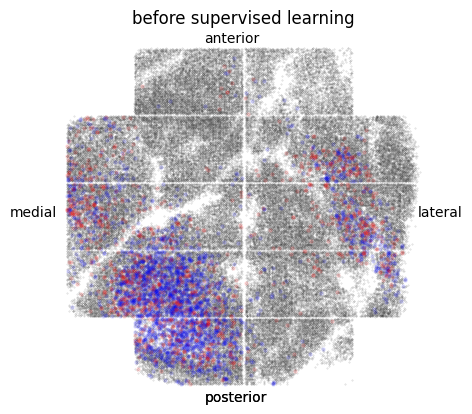

In [13]:
# @title Plot the location of selective neurons
thr = 0.6 # set d-prime threshold
stim1_sel = dprime_pc_bef >=  thr # stim1 selective neurons
stim2_sel = dprime_pc_bef <= -thr # stim2 selective neurons

retin = np.load(os.path.join(root, sup_bef[:-1]+'trans.npz'), allow_pickle=1) # load retinotopy information
xpos = retin['xpos']/0.75 # divided by pixel size (0.75) along x direction
ypos = retin['ypos']/0.5 # divided by pixel size (0.5) along y direction

fig = plt.figure()
ax = plt.gca()
ax.set_aspect('equal')
plt.axis('off')

plt.scatter(-ypos, xpos, c='k', s=0.1, alpha=0.2) # plot all neurons (use as background)
plt.scatter(-ypos[stim1_sel], xpos[stim1_sel], c='b', s=5, alpha=0.1, label='selective to stim1') # stim1 selective neurons
plt.scatter(-ypos[stim2_sel], xpos[stim2_sel], c='r', s=5, alpha=0.1, label='selective to stim2') # stim2 selective neurons

plt.text(-0.1, 0.5, 'medial', transform=ax.transAxes)
plt.text(0.95, 0.5, 'lateral', transform=ax.transAxes)
plt.text(0.4, 0.97, 'anterior', transform=ax.transAxes)
plt.text(0.4, 0, 'posterior', transform=ax.transAxes)
plt.text(0.4, 0, 'posterior', transform=ax.transAxes)
plt.title('before supervised learning')
plt.show()

In [14]:
# @title Rewriting code above into a function to get the d-prime for other sessions (mice)
def cal_dprime(root, m_name, exp, stim1_ID=2, stim2_ID=0):
    """m_name: name of recording
       exp: experiment
       stim1_ID and stim2_ID: ID of stimulus 1 and 2, 0:circle1, 1:circle2, 2:leaf1, 3:leaf2, 4:leaf3;
       rewarded stimulus (leaf1) for supervised experiment, non-rewarded stimulus (circle1) for supervised experiment
    """
    # load behavior data
    beh = np.load(os.path.join(root, exp), allow_pickle=1).item()[m_name]
    stim_id = beh['stim_id'] # 0:circle1, 1:circle2, 2:leaf1, 3:leaf2, 4:leaf3
    ntrials, uniqW, WallN, SoundPos = beh['ntrials'], beh['UniqWalls'], beh['WallName'], beh['SoundPos']

    stim_fr = beh['ft_WallID'] # trial stimulus of each frame
    pos_fr = beh['ft_Pos'] # position of each frame inside corridor
    VR_move = beh['ft_move']>0 # frames with virtual scence moving

    name_stim1 = uniqW[stim_id==stim1_ID][0] # name of stimulus 1;
    name_stim2 = uniqW[stim_id==stim2_ID][0] # name of stimulus 2;

    stim1_idx = (stim_fr==name_stim1) & (pos_fr<40)
    stim2_idx = (stim_fr==name_stim2) & (pos_fr<40)

    idx1 = stim1_idx & VR_move # only take frames while mouse is running inside the texture area
    idx2 = stim2_idx & VR_move
    svd_ = np.load(os.path.join(root, m_name + '_SVD_dec.npy'), allow_pickle=1).item()
    proj = svd_['U'].T @ svd_['V'] # project from the PC space back to neural space
    del svd_
    nfrs = proj.shape[1]
    # using the function 'dprime' if you have more RAM, otherwise use a for loop
    # dp = dprime(proj[:, idx1[:nfrs]], proj[:, idx2[:nfrs]]) # get d-prime
    u1, u2, sig1, sig2 = np.empty(proj.shape[0]), np.empty(proj.shape[0]), np.empty(proj.shape[0]), np.empty(proj.shape[0])
    for n in range(proj.shape[0]):
        u1[n] = np.nanmean(proj[n, idx1[:nfrs]])
        u2[n] = np.nanmean(proj[n, idx2[:nfrs]])
        sig1[n] = np.nanstd(proj[n, idx1[:nfrs]])
        sig2[n] = np.nanstd(proj[n, idx2[:nfrs]])
    dp = 2 * (u1 - u2) / (sig1 + sig2) # get d-prime
    del proj
    retin = np.load(os.path.join(root, m_name[:-1]+'trans.npz'), allow_pickle=1)
    xpos, ypos = retin['xpos']/0.75, retin['ypos']/0.5

    return {'dp':dp, 'xpos':xpos, 'ypos':ypos, 'iarea':retin['iarea']}

## Calculate d-prime for supervised mouse, before and after learning

In [15]:
dp_sup_bef = cal_dprime(root, sup_bef, 'Beh_sup_train1_before_learning.npy')
dp_sup_aft = cal_dprime(root, sup_aft, 'Beh_sup_train1_after_learning.npy')

### Plot the distribution of selective neurons from before and after learning

/tmp/ipython-input-16-3747314608.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


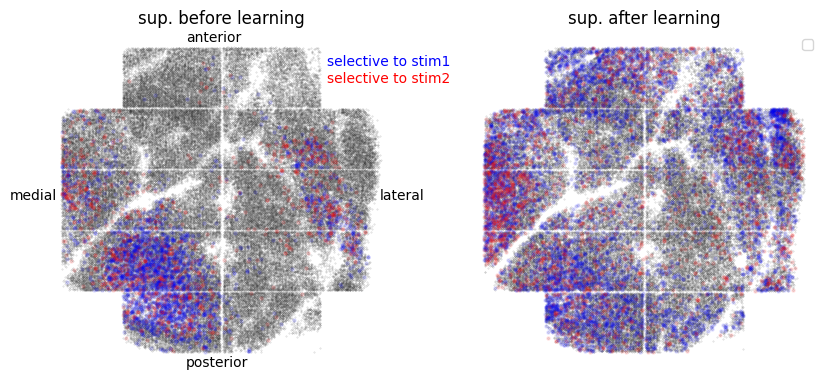

In [16]:
thr = 0.6 # set d-prime threshold, you can check how this impacts analyses

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# supervised, before learning
axes[0].scatter(-dp_sup_bef['ypos'], dp_sup_bef['xpos'], c='k', s=0.1, alpha=0.2)
axes[0].scatter(-dp_sup_bef['ypos'][dp_sup_bef['dp'] >= thr], dp_sup_bef['xpos'][dp_sup_bef['dp'] >= thr], c='b', s=5, alpha=0.1, label='selective to stim1')
axes[0].scatter(-dp_sup_bef['ypos'][dp_sup_bef['dp'] <= -thr], dp_sup_bef['xpos'][dp_sup_bef['dp'] <= -thr], c='r', s=5, alpha=0.1, label='selective to stim1')
axes[0].set_title('sup. before learning')
axes[0].set_aspect('equal')
axes[0].text(-0.1, 0.5, 'medial', transform=axes[0].transAxes)
axes[0].text(0.95, 0.5, 'lateral', transform=axes[0].transAxes)
axes[0].text(0.4, 0.97, 'anterior', transform=axes[0].transAxes)
axes[0].text(0.4, 0, 'posterior', transform=axes[0].transAxes)
axes[0].text(0.8, 0.9, 'selective to stim1', color='b', transform=axes[0].transAxes)
axes[0].text(0.8, 0.85, 'selective to stim2', color='r', transform=axes[0].transAxes)
axes[0].axis('off')

# supervised, after learning
axes[1].scatter(-dp_sup_aft['ypos'], dp_sup_aft['xpos'], c='k', s=0.1, alpha=0.2)
axes[1].scatter(-dp_sup_aft['ypos'][dp_sup_aft['dp'] >= thr], dp_sup_aft['xpos'][dp_sup_aft['dp'] >= thr], c='b', s=5, alpha=0.1)
axes[1].scatter(-dp_sup_aft['ypos'][dp_sup_aft['dp'] <= -thr], dp_sup_aft['xpos'][dp_sup_aft['dp'] <= -thr], c='r', s=5, alpha=0.1)
axes[1].set_title('sup. after learning')
axes[1].set_aspect('equal')
axes[1].axis('off')
plt.legend()
plt.show()

## Calculate d-prime for unsupervised mouse, before and after learning

In [17]:
# dprimes for unsupervised mice
dp_unsup_bef = cal_dprime(root, unsup_bef, 'Beh_unsup_train1_before_learning.npy')
dp_unsup_aft = cal_dprime(root, unsup_aft, 'Beh_unsup_train1_after_learning.npy')

### Plot distribution of selective neurons

/tmp/ipython-input-18-1824406948.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


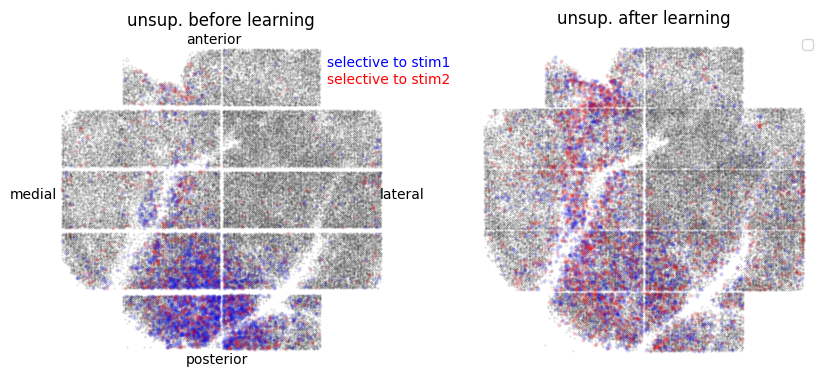

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# unsupervised, before learning
axes[0].scatter(-dp_unsup_bef['ypos'], dp_unsup_bef['xpos'], c='k', s=0.1, alpha=0.2)
axes[0].scatter(-dp_unsup_bef['ypos'][dp_unsup_bef['dp'] >= thr], dp_unsup_bef['xpos'][dp_unsup_bef['dp'] >= thr], c='b', s=5, alpha=0.1, label='selective to stim1')
axes[0].scatter(-dp_unsup_bef['ypos'][dp_unsup_bef['dp'] <= -thr], dp_unsup_bef['xpos'][dp_unsup_bef['dp'] <= -thr], c='r', s=5, alpha=0.1, label='selective to stim1')
axes[0].set_title('unsup. before learning')
axes[0].set_aspect('equal')
axes[0].text(-0.1, 0.5, 'medial', transform=axes[0].transAxes)
axes[0].text(0.95, 0.5, 'lateral', transform=axes[0].transAxes)
axes[0].text(0.4, 0.97, 'anterior', transform=axes[0].transAxes)
axes[0].text(0.4, 0, 'posterior', transform=axes[0].transAxes)
axes[0].text(0.8, 0.9, 'selective to stim1', color='b', transform=axes[0].transAxes)
axes[0].text(0.8, 0.85, 'selective to stim2', color='r', transform=axes[0].transAxes)
axes[0].axis('off')

# unsupervised, after learning
axes[1].scatter(-dp_unsup_aft['ypos'], dp_unsup_aft['xpos'], c='k', s=0.1, alpha=0.2)
axes[1].scatter(-dp_unsup_aft['ypos'][dp_unsup_aft['dp'] >= thr], dp_unsup_aft['xpos'][dp_unsup_aft['dp'] >= thr], c='b', s=5, alpha=0.1)
axes[1].scatter(-dp_unsup_aft['ypos'][dp_unsup_aft['dp'] <= -thr], dp_unsup_aft['xpos'][dp_unsup_aft['dp'] <= -thr], c='r', s=5, alpha=0.1)
axes[1].set_title('unsup. after learning')
axes[1].set_aspect('equal')
axes[1].axis('off')
plt.legend()
plt.show()

## Compare the increase in selective neurons for visual cortical regions

In [19]:
# function used for define which brain area a neuron belong to
def neu_area_ID(iarea):
    area_name = ['V1', 'mHV', 'lHV', 'aHV']
    idx = {}
    for ar in area_name:
        if ar=='V1':
            idx[ar] = iarea==8
        elif ar=='mHV':
            idx[ar] = (iarea==0) | (iarea==1) | (iarea==2) | (iarea==9)
        elif ar=='lHV':
            idx[ar] = (iarea==5) | (iarea==6)
        elif ar=='aHV':
            idx[ar] = (iarea==3) | (iarea==4)
    return idx

In [20]:
sup_bef_neu_info = neu_area_ID(dp_sup_bef['iarea'])
sup_aft_neu_info = neu_area_ID(dp_sup_aft['iarea'])
unsup_bef_neu_info = neu_area_ID(dp_unsup_bef['iarea'])
unsup_aft_neu_info = neu_area_ID(dp_sup_aft['iarea'])


# get fraction of neurons with d-prime above threshold
dp_thr = 0.6
frac = np.empty((4, 4))
for i, idp in enumerate([dp_sup_bef, dp_sup_aft, dp_unsup_bef, dp_unsup_aft]):
    sel_neu = abs(idp['dp']) >= dp_thr # include both stim1 and stim2 selective neurons
    ar_Ind = neu_area_ID(idp['iarea'])
    for j, jar in enumerate(['V1', 'mHV', 'lHV', 'aHV']):
        frac[i, j] = 100 * sel_neu[ar_Ind[jar]].sum() / ar_Ind[jar].sum()
frac = np.array(frac)

## Plot fraction of selective neurons across visual cortical regions

(0.0, 20.0)

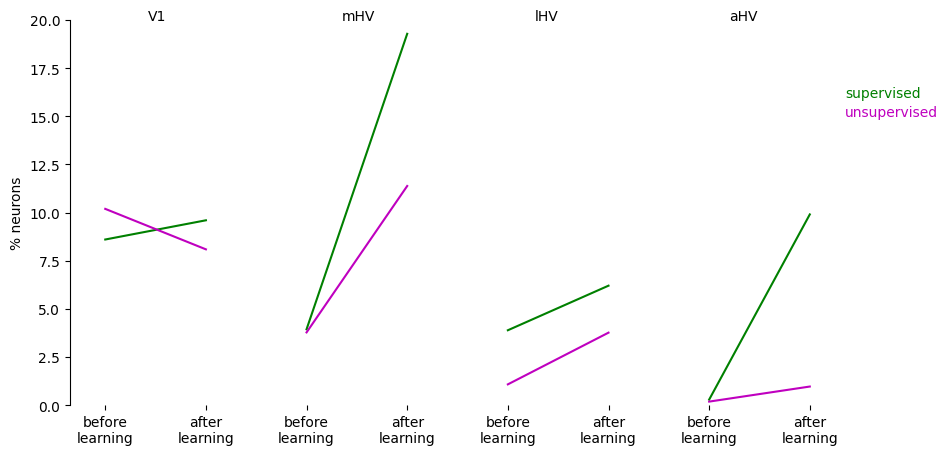

In [21]:
fig = plt.figure(figsize=(10, 5))
ax = plt.gca()
plt.plot([np.arange(4), np.arange(4)+0.5], frac[0:2], color='g', label='supervised')
plt.plot([np.arange(4), np.arange(4)+0.5], frac[2:], color='m', label='unsupervised')
plt.ylabel('% neurons')
plt.xticks(np.arange(8)/2, ['before\nlearning', 'after\nlearning']*4)
for a, ar in enumerate(['V1', 'mHV', 'lHV', 'aHV']):
    plt.text(0.1+0.25*a, 1, ar, transform=ax.transAxes)
plt.text(1, 0.8, 'supervised', color='g',transform=ax.transAxes)
plt.text(1, 0.75, 'unsupervised', color='m',transform=ax.transAxes)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.ylim([0, 20])

In [22]:
# @title Novel stimuli data loading and imports

# set path for data
root = r'/content/Zhong_et_al_2025'
Path(root).mkdir(exist_ok=True)

# files required for this project: 'VR2_2021_04_11_1_SVD_dec.npy'; 'VR2_2021_04_11_trans.npz'; 'Beh_sup_test1.npy'
#                                  'TX105_2022_10_21_1_SVD_dec.npy'; 'TX105_2022_10_21_trans.npz'; 'Beh_unsup_test1.npy'
sup_test1 = 'VR2_2021_04_11_1' #example task mouse in test1 with new stimuli
unsup_test1 = 'TX105_2022_10_21_1' #example unsupervised mouse in test1 with new stimuli

# download files from Figshare
file_ID = [54866360, 54184217, 54183875, 54866243, 54184034, 54183911] # IDs of files

BASE_URL = 'https://api.figshare.com/v2'
r = requests.get(BASE_URL + '/articles/' + str(28811129)) # 28811129 is the ID of the whole dataset
file_metadata = json.loads(r.text)
for file in file_metadata['files']:
  if file['id'] in file_ID: # only download files included in file_ID
    fn = os.path.join(root, file['name'])
    if not os.path.isfile(fn):
      response = requests.get(BASE_URL + '/file/download/' + str(file['id']))
      open(fn, 'wb').write(response.content)

In [23]:
# @title Calculate dprime for both leaf1 (learned) and leaf2 (new), with circle1 (learned) as reference

# To get dprime for circle2 (new), use leaf1 as reference (ie. stim1_ID=1 and stim2_ID=2) instead

dp_sup_test1_leaf2_circle1 = cal_dprime(root, sup_test1, 'Beh_sup_test1.npy', stim1_ID=3, stim2_ID=0)
dp_unsup_test1_leaf2_circle1 = cal_dprime(root, unsup_test1, 'Beh_unsup_test1.npy', stim1_ID=3, stim2_ID=0)
dp_sup_test1_leaf1_circle1 = cal_dprime(root, sup_test1, 'Beh_sup_test1.npy', stim1_ID=2, stim2_ID=0)
dp_unsup_test1_leaf1_circle1 = cal_dprime(root, unsup_test1, 'Beh_unsup_test1.npy', stim1_ID=2, stim2_ID=0)

sup_test1_neu_info = neu_area_ID(dp_sup_test1_leaf1_circle1['iarea'])
unsup_test1_neu_info = neu_area_ID(dp_unsup_test1_leaf1_circle1['iarea'])

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator TruncatedSVD from version 1.6.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


/tmp/ipython-input-24-2901806670.py:41: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


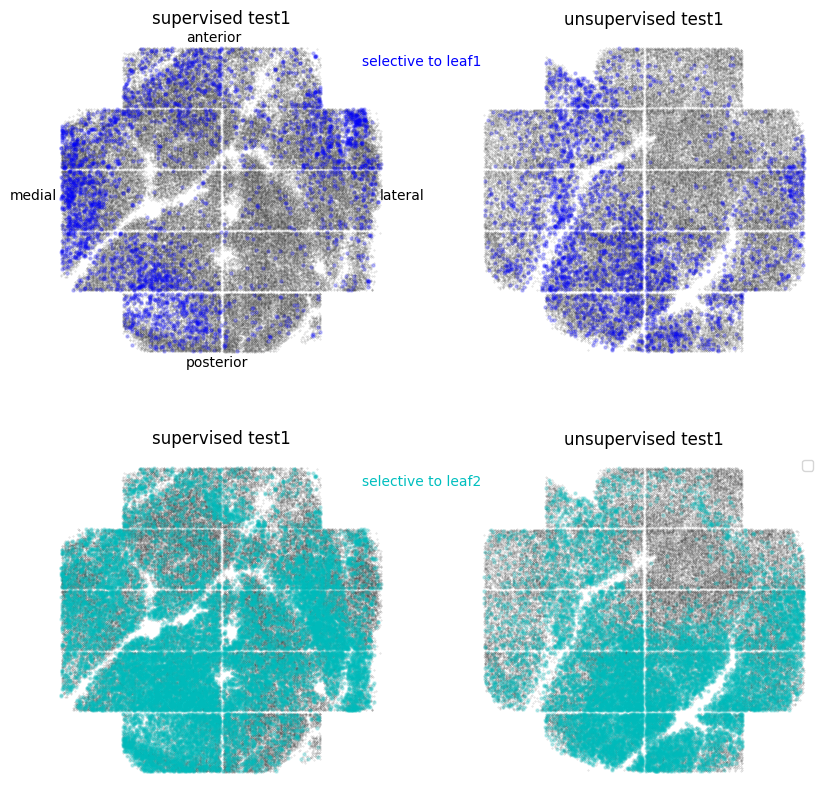

In [24]:
# @title Plot the location of selective neurons
thr = 0.6 # set d-prime threshold, you can check how this impacts analyses

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# supervised, test1, leaf1 selective neurons
axes[0, 0].scatter(-dp_sup_test1_leaf1_circle1['ypos'], dp_sup_test1_leaf1_circle1['xpos'], c='k', s=0.1, alpha=0.2)
axes[0, 0].scatter(-dp_sup_test1_leaf1_circle1['ypos'][dp_sup_test1_leaf1_circle1['dp'] >= thr], dp_sup_test1_leaf1_circle1['xpos'][dp_sup_test1_leaf1_circle1['dp'] >= thr], c='b', s=5, alpha=0.2)
axes[0, 0].set_title('supervised test1')
axes[0, 0].set_aspect('equal')
axes[0, 0].text(-0.1, 0.5, 'medial', transform=axes[0, 0].transAxes)
axes[0, 0].text(0.95, 0.5, 'lateral', transform=axes[0, 0].transAxes)
axes[0, 0].text(0.4, 0.97, 'anterior', transform=axes[0, 0].transAxes)
axes[0, 0].text(0.4, 0, 'posterior', transform=axes[0, 0].transAxes)
axes[0, 0].text(0.9, 0.9, 'selective to leaf1', color='b', transform=axes[0, 0].transAxes)
axes[0, 0].axis('off')

# unsupervised, test1, leaf1 selective neurons
axes[0, 1].scatter(-dp_unsup_test1_leaf1_circle1['ypos'], dp_unsup_test1_leaf1_circle1['xpos'], c='k', s=0.1, alpha=0.2)
axes[0, 1].scatter(-dp_unsup_test1_leaf1_circle1['ypos'][dp_unsup_test1_leaf1_circle1['dp'] >= thr], dp_unsup_test1_leaf1_circle1['xpos'][dp_unsup_test1_leaf1_circle1['dp'] >= thr], c='b', s=5, alpha=0.2)
axes[0, 1].set_title('unsupervised test1')
axes[0, 1].set_aspect('equal')
axes[0, 1].axis('off')


# supervised, test1, leaf2 selective neurons
axes[1, 0].scatter(-dp_sup_test1_leaf1_circle1['ypos'], dp_sup_test1_leaf1_circle1['xpos'], c='k', s=0.1, alpha=0.2)
axes[1, 0].scatter(-dp_sup_test1_leaf2_circle1['ypos'][dp_sup_test1_leaf2_circle1['dp'] >= thr], dp_sup_test1_leaf2_circle1['xpos'][dp_sup_test1_leaf2_circle1['dp'] >= thr], c='c', s=5, alpha=0.2)
axes[1, 0].set_title('supervised test1')
axes[1, 0].set_aspect('equal')
axes[1, 0].text(0.9, 0.9, 'selective to leaf2', color='c', transform=axes[1, 0].transAxes)
axes[1, 0].axis('off')

# unsupervised, test1, leaf2 selective neurons
axes[1, 1].scatter(-dp_unsup_test1_leaf2_circle1['ypos'], dp_unsup_test1_leaf2_circle1['xpos'], c='k', s=0.1, alpha=0.2)
axes[1, 1].scatter(-dp_unsup_test1_leaf2_circle1['ypos'][dp_unsup_test1_leaf2_circle1['dp'] >= thr], dp_unsup_test1_leaf2_circle1['xpos'][dp_unsup_test1_leaf2_circle1['dp'] >= thr], c='c', s=5, alpha=0.2)
axes[1, 1].set_title('unsupervised test1')
axes[1, 1].set_aspect('equal')
axes[1, 1].axis('off')

plt.legend()
plt.show()